In [20]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import joblib

from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score, \
                            auc, confusion_matrix, accuracy_score, \
                            classification_report

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

from sklearn.pipeline import Pipeline
pd.set_option('display.float_format', '{:.2f}'.format)

In [21]:
df_data_general = pd.read_csv('../../data/data_general.csv')

In [22]:
df_data_general['INITIAL_TIME'] = pd.to_datetime(df_data_general['INITIAL_TIME'])
df_data_general['FINAL_TIME'] = pd.to_datetime(df_data_general['FINAL_TIME'])

In [23]:
df_data_general['INITIAL_TIME'] = df_data_general['INITIAL_TIME'].dt.to_period('D')
df_data_general['INITIAL_TIME'] = df_data_general['INITIAL_TIME'].dt.to_timestamp()


df_data_general['FINAL_TIME'] = df_data_general['FINAL_TIME'].dt.to_period('D')
df_data_general['FINAL_TIME'] = df_data_general['FINAL_TIME'].dt.to_timestamp()

In [24]:
df_data_general['Weekday']= df_data_general['INITIAL_TIME'].dt.strftime('%A')
df_data_general['number_of_day'] = df_data_general['INITIAL_TIME'].dt.day_of_week

In [25]:
df_data_general[['number_of_day', 'INITIAL_AMOUNT', 'BET_TOTAL', 'TIME_ON_DEVICE_SEC', 'GAMES_PLAYED_TOTAL']].corr(method='spearman')

,number_of_day,INITIAL_AMOUNT,BET_TOTAL,TIME_ON_DEVICE_SEC,GAMES_PLAYED_TOTAL
number_of_day,1.00,0.01,0.01,0.02,0.01
INITIAL_AMOUNT,0.01,1.00,0.45,0.17,0.20
BET_TOTAL,0.01,0.45,1.00,0.80,0.85
TIME_ON_DEVICE_SEC,0.02,0.17,0.80,1.00,0.93
GAMES_PLAYED_TOTAL,0.01,0.20,0.85,0.93,1.00


<Axes: xlabel='INITIAL_TIME', ylabel='AVG_BET'>

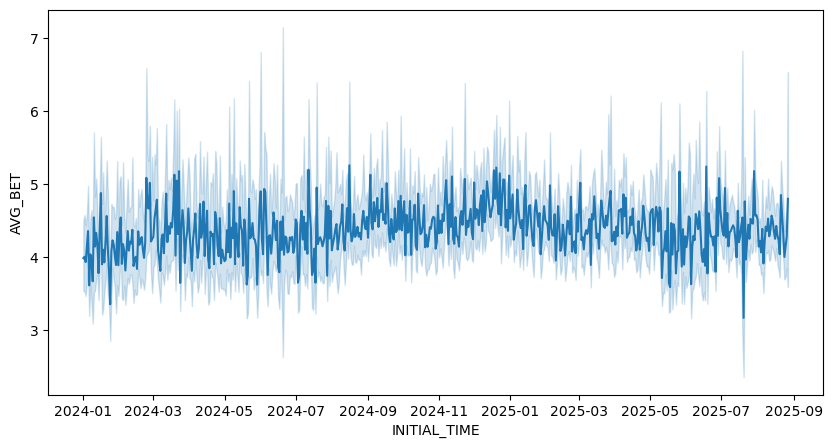

In [26]:
plt.figure(figsize=(10,5))
sns.lineplot(x=df_data_general['INITIAL_TIME'], y=df_data_general['AVG_BET'])

<Axes: xlabel='number_of_day', ylabel='TIME_ON_DEVICE_SEC'>

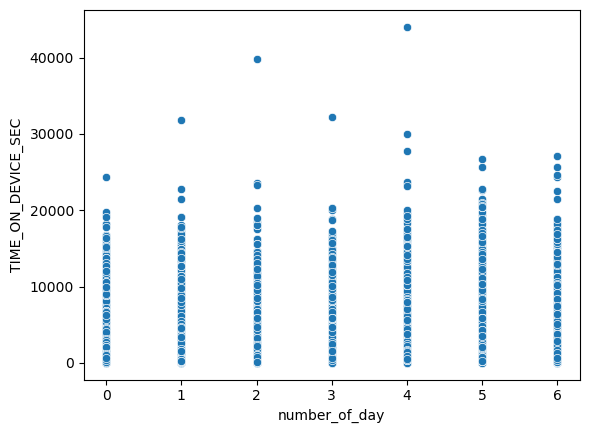

In [27]:
sns.scatterplot(x=df_data_general['number_of_day'], y=df_data_general['TIME_ON_DEVICE_SEC'])

In [28]:
df_data_general['NET_SPEND'] = df_data_general['FINAL_AMOUNT'] - df_data_general['INITIAL_AMOUNT']

In [29]:
df_data_general['TIME_ON_DEVICE_MIN'] = df_data_general['TIME_ON_DEVICE_SEC'] / 60

In [30]:
df_group = df_data_general.groupby(['PLAYER_ID','Weekday'])['BET_TOTAL'].mean().reset_index()

In [31]:
# Features (ejemplo: puedes ajustar)
X = df_data_general[['AVG_BET','Cluster','number_of_day']]
y = df_data_general['TIME_ON_DEVICE_MIN']

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# modelo
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# evaluación
y_pred = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))


MAE: 8.79465466877582
R2: 0.5745481915109447


In [32]:
q25, q50, q75 = df_data_general['TIME_ON_DEVICE_SEC'].quantile([0.25, 0.5, 0.75])

bins = [0, q25, q50, q75, float('inf')]
labels = [0, 1, 2, 3]

df_data_general['time_on_device_label'] = pd.cut(
    df_data_general['TIME_ON_DEVICE_SEC'],
    bins=bins,
    labels=labels,
    include_lowest=True
).astype(int)

In [33]:
std_scaler = StandardScaler()
X = df_data_general[['AVG_BET','Cluster','number_of_day']]
y = df_data_general['time_on_device_label']

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
knn = Pipeline([
        ('scaler', std_scaler),
        ('clf', KNeighborsClassifier(n_neighbors=4))
    ])
knn.fit(X_train, y_train)

y_hat = knn.predict(X_test)

print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.41      0.55      0.47     11426
           1       0.30      0.30      0.30     11318
           2       0.32      0.28      0.30     11255
           3       0.60      0.47      0.53     11348

    accuracy                           0.40     45347
   macro avg       0.41      0.40      0.40     45347
weighted avg       0.41      0.40      0.40     45347



In [34]:
df_data_general['Hour'] = df_data_general['INITIAL_TIME'].dt.hour
df_data_general['Weekday'] = df_data_general['INITIAL_TIME'].dt.weekday   # 0=Lunes, 6=Domingo
df_data_general['Weekend'] = (df_data_general['Weekday'] >= 5).astype(int)
df_data_general['Month'] = df_data_general['INITIAL_TIME'].dt.month

In [35]:
df_data_general = df_data_general[df_data_general['TIME_ON_DEVICE_MIN'] < 600 ]

In [41]:
features = ['INITIAL_AMOUNT','AVG_BET','Cluster','Weekday','Weekend','Month']

X = df_data_general[features]
y = df_data_general['TIME_ON_DEVICE_MIN']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predicción
y_pred = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))

MAE: 8.608416352422253
R2: 0.6153862161977262


In [44]:
std_scaler = StandardScaler()
pipe = Pipeline([
        ('scaler', std_scaler),
        ('reg', RandomForestRegressor())
    ])

pipe.fit(X_train, y_train)

y_hat = pipe.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_hat))
print("R2:", r2_score(y_test, y_hat))

MAE: 8.613172783404302
R2: 0.6151213765080965


<Axes: xlabel='TIME_ON_DEVICE_MIN'>

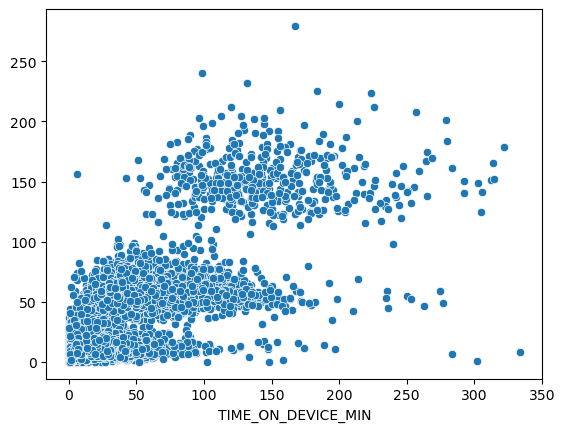

In [43]:
sns.scatterplot(x=y_test, y=y_hat)

In [45]:
joblib.dump(pipe, '../../models/time_on_device_pipeline_regressor_foliattiGeneral_v1.pkl')

['../../models/time_on_device_pipeline_regressor_foliattiGeneral_v1.pkl']